In [1]:
# external libraries for visualizations and data manipulation
# ensure that these packages have been installed prior to calls
import pandas as pd  # data frame operations  
import numpy as np  # arrays and math functions
import matplotlib.pyplot as plt  # static plotting
import seaborn as sns  # pretty plotting, including heat map
np.set_printoptions(precision=3)

import os
os.getcwd()
os.chdir('C:\\Users\\enisbe\\Google Drive New\\NW\\MSDS 422\\Data\\')
covid = pd.read_csv('COVID19_4122020.csv')
pd.options.display.float_format = '{:.3f}'.format
sns.set()

In [2]:
def corr_chart(df_corr):
    corr=df_corr.corr()
    #screen top half to get a triangle
    top = np.zeros_like(corr, dtype=np.bool)
    top[np.triu_indices_from(top)] = True
    fig=plt.figure()
    fig, ax = plt.subplots(figsize=(12,12))
    sns.heatmap(corr, mask=top, cmap='coolwarm', 
        center = 0, square=True, 
        linewidths=.5, cbar_kws={'shrink':.5}, 
        annot = True, annot_kws={'size': 9}, fmt = '.3f')     ;       
    plt.xticks(rotation=45) # rotate variable labels on columns (x axis)
    plt.yticks(rotation=0) # use horizontal variable labels on rows (y axis)
    plt.title('Correlation Heat Map')  
 

# Data Quality Assesment

Steps to take:

* Describe the data
* Get data types
* Convert date strings to pandas dates
* Check for missing

In [3]:
covid.describe()

,day,month,year,cases,deaths,popData2018
count,10332.000,10332.000,10332.000,10332.000,10332.000,10169.000
mean,15.149,2.703,2019.994,167.916,10.472,62216963.442
std,9.153,1.290,0.080,1293.232,84.744,197652842.822
min,1.000,1.000,2019.000,-9.000,0.000,1000.000
25%,7.000,2.000,2020.000,0.000,0.000,3170208.000
50%,14.000,3.000,2020.000,1.000,0.000,10183175.000
75%,23.000,3.000,2020.000,16.000,0.000,42228429.000
max,31.000,12.000,2020.000,35527.000,2087.000,1392730000.000


In [4]:
print("-------------Print Number of Countries in the dataset----------------------")
len(covid.countryterritoryCode.unique())

-------------Print Number of Countries in the dataset----------------------


202

In [5]:
#Check columns types values by column
covid.dtypes

Date                        object
day                          int64
month                        int64
year                         int64
cases                        int64
deaths                       int64
countriesAndTerritories     object
geoId                       object
countryterritoryCode        object
popData2018                float64
dtype: object

In [6]:
#Convert date to pandas date
covid.Date = pd.to_datetime(covid.Date,format="%m/%d/%Y")

In [9]:
#Check missing values by column
covid.isnull().sum()

Date                         0
day                          0
month                        0
year                         0
cases                        0
deaths                       0
countriesAndTerritories      0
geoId                       29
countryterritoryCode       205
popData2018                163
dtype: int64

# Basic Exploration

To simply the analysis we will consider only 15 states that are impacted the most. <br>
15 countries have 86% of the cases recorded world wide. Data for countries might result in too much noise and not provide meaningful analysis. <br>
In this step we will also do the variable transformation including estimation of cases per million, doubling rates, mortality rates and others. <br>
THis step will make plots of cases and deaths by country. 



In [8]:
#To simplfy the analysis we will take only first 15 state that have the largest 
summary_of_case = pd.Series(covid.groupby('geoId')['cases'].sum().transform(pd.Series.sort_values, ascending=False))
summary_of_case = pd.DataFrame(summary_of_case).reset_index()
listFilter = summary_of_case.geoId.tolist()
listFilter =listFilter[0:15]

print("----------Top 15 countries with infections----------")
summary_of_case [summary_of_case['geoId'].isin(listFilter)]

----------Top 15 countries with infections----------


,geoId,cases
0,US,529951
1,ES,161852
2,IT,152271
3,DE,120479
4,FR,93790
5,CN,83097
6,UK,78991
7,IR,70029
8,TR,52167
9,BE,28018


In [9]:
print("Total World Cases: ", round(summary_of_case.cases.sum(),4))  
print("15 most affected countries:", round(summary_of_case [summary_of_case['geoId'].isin(listFilter)].cases.sum(),0))
print("Percentage of Cases in 15 most affected countries: ",    
      round(summary_of_case [summary_of_case['geoId'].isin(listFilter)].cases.sum()/summary_of_case.cases.sum() ,4))



Total World Cases:  1734897
15 most affected countries: 1479893
Percentage of Cases in 15 most affected countries:  0.853


In [10]:
covid = covid[covid['geoId'].isin(listFilter)] 
print('-------------Missing value for 15 countries-----------------')
covid.isnull().sum() 

-------------Missing value for 15 countries-----------------


Date                       0
day                        0
month                      0
year                       0
cases                      0
deaths                     0
countriesAndTerritories    0
geoId                      0
countryterritoryCode       0
popData2018                0
dtype: int64

In [11]:
print("------------------Countries and codes-----------------------")
covid.groupby(['countriesAndTerritories','countryterritoryCode'])['cases'].max().reset_index()[['countriesAndTerritories','countryterritoryCode']]

------------------Countries and codes-----------------------


,countriesAndTerritories,countryterritoryCode
0,Belgium,BEL
1,Brazil,BRA
2,Canada,CAN
3,China,CHN
4,France,FRA
5,Germany,DEU
6,Iran,IRN
7,Italy,ITA
8,Netherlands,NLD
9,Portugal,PRT


In [12]:
#create some variables transformations such as cases per million, death per million, empirical double time for deaths and cases 

covid = covid.sort_values(by=['geoId','Date'], ascending=[False,True])
covid['cum_cases'] = covid.groupby('geoId')['cases'].cumsum()
covid['cum_deaths'] = covid.groupby('geoId')['deaths'].cumsum()
covid['mortality_rate'] = covid['cum_deaths']/covid['cum_cases'] 
covid['case_change']=covid.groupby(['geoId'])['cum_cases'].pct_change()
covid['death_change']=covid.groupby(['geoId'])['cum_deaths'].pct_change()
covid['case_change']=covid.case_change.fillna(0)
covid['death_change']=covid.death_change.fillna(0)
covid['case_change_roll3']= covid.case_change.rolling(3 ).mean()
covid['death_change_roll3']= covid.death_change.rolling(3 ).mean()
covid['case_change_roll3']=covid.case_change.fillna(0)
covid['death_change_roll3']=covid.death_change.fillna(0)
covid['double_time_case']  = 1/covid.case_change_roll3
covid['double_time_deaths']  = 1/covid.death_change_roll3
covid['cum_cases_per_million'] = covid['cum_cases']/(covid['popData2018']/1000000)
covid['new_cases_per_million'] = covid['cases']/(covid['popData2018']/1000000)
covid['cum_death_per_million'] = covid['cum_deaths']/(covid['popData2018']/1000000)
covid['new_death_per_million'] = covid['deaths']/(covid['popData2018']/1000000)
covid.replace([np.inf, -np.inf], np.nan,inplace=True)

 

* for the following analysis we want to focus on the countries only after the point where they reach 100 cases in total 
* based on this information we can creates index that counts days from the time the country reaches 100 case
* We can then compare countries and the virus spread based on this index
* By eliminating cases and observations less then 100 commulative cases we reduce the noise in the data 


In [13]:
#or the following analysis we want to focus on the countries only after the point where they reach 100 cases in total 
#Based on this information we can creates index that counts days from the time the country reaches 100 case
#We can then compare countries and the virus spread based on this index
#By eliminating cases and observations less then 100 commulative cases we reduce the noise in the data 

import copy
covid_gt100 = covid.copy() 
covid_gt100 = covid_gt100[covid_gt100.cum_cases >=100]
covid_gt100['days_since_100']= covid_gt100.groupby('geoId').cumcount()


----------  Average Cases per Million ----------------
592.0 

----------  Average Deaths per Million ----------------
40.0 



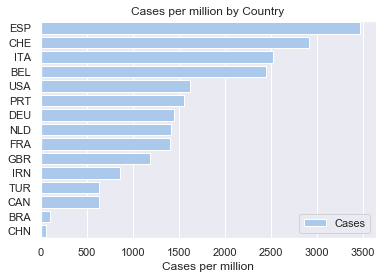

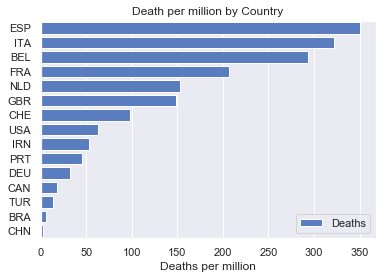

In [14]:
#plot cummulative deaths and cummulative cases per million per capita for 15 countries

df_deaths= pd.DataFrame(covid.groupby('countryterritoryCode')['cum_death_per_million'].max().transform(pd.Series.sort_values,ascending=False)).reset_index()
df_cases = pd.DataFrame(covid.groupby('countryterritoryCode')['cum_cases_per_million'].max().transform(pd.Series.sort_values,ascending=False)).reset_index()

total_pop = covid.groupby('countryterritoryCode')['popData2018'].max().sum()

print("----------  Average Cases per Million ----------------")
print(round(covid['cases'].sum()/(total_pop/1000000),0), "\n")
 
print("----------  Average Deaths per Million ----------------")
print(round(covid['deaths'].sum()/(total_pop/1000000),0), "\n")

f, ax = plt.subplots()
sns.set_color_codes("pastel")
sns.barplot(x="cum_cases_per_million", y="countryterritoryCode", data=df_cases,label="Cases", color="b")
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(ylabel="", xlabel="Cases per million")
plt.title("Cases per million by Country")


f, ax = plt.subplots( )
sns.set_color_codes("muted")
sns.barplot(x="cum_death_per_million", y="countryterritoryCode", data=df_deaths, label="Deaths", color="b")
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(ylabel="", xlabel="Deaths per million")
# sns.despine(left=True, bottom=True)
plt.title("Death per million by Country");

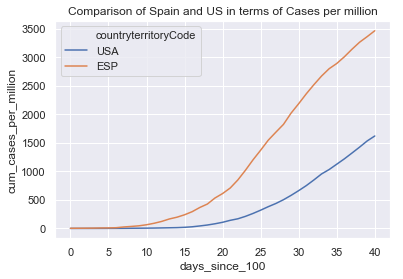

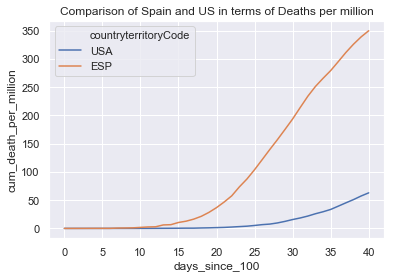

In [15]:
# Comparison of case per million and deaths per million for US and Spain (most case and deaths per million). 

filt = ["USA","ESP"]
mask = covid_gt100.countryterritoryCode.isin(filt)
ax = sns.lineplot(x="days_since_100", y="cum_cases_per_million", hue="countryterritoryCode", data=covid_gt100[mask])
plt.title("Comparison of Spain and US in terms of Cases per million")

f, ax = plt.subplots()
ax = sns.lineplot(x="days_since_100", y="cum_death_per_million", hue="countryterritoryCode", data=covid_gt100[mask]);
plt.title("Comparison of Spain and US in terms of Deaths per million");
 

---------Average Mortality rate -------------
0.068 

---------Average Mortality rate by country (Latest recorded)-------------


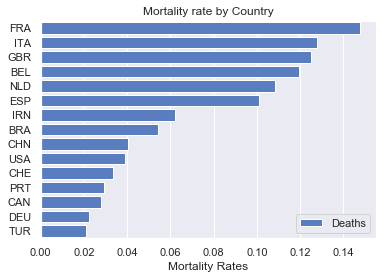

In [16]:
# Graph mortality rates  
print('---------Average Mortality rate -------------')
print(round(covid_gt100['deaths'].sum()/covid_gt100['cases'].sum(),3), "\n")


print('---------Average Mortality rate by country (Latest recorded)-------------')
df_mortality =pd.DataFrame(covid_gt100.groupby('countryterritoryCode')['mortality_rate'].last().transform(pd.Series.sort_values,ascending=False)).reset_index()

f, ax = plt.subplots()
sns.set_color_codes("muted")
sns.barplot(x="mortality_rate", y="countryterritoryCode", data=df_mortality, label="Deaths", color="b")



ax.legend(ncol=1, loc="lower right", frameon=True)
ax.set(  ylabel="", xlabel="Mortality Rates")
# sns.despine(left=True, bottom=True)
plt.title("Mortality rate by Country");


# Correlations

With indexed data we can perform correlations

-----correlation of doubling time of case for 15 countries-----------


<Figure size 432x288 with 0 Axes>

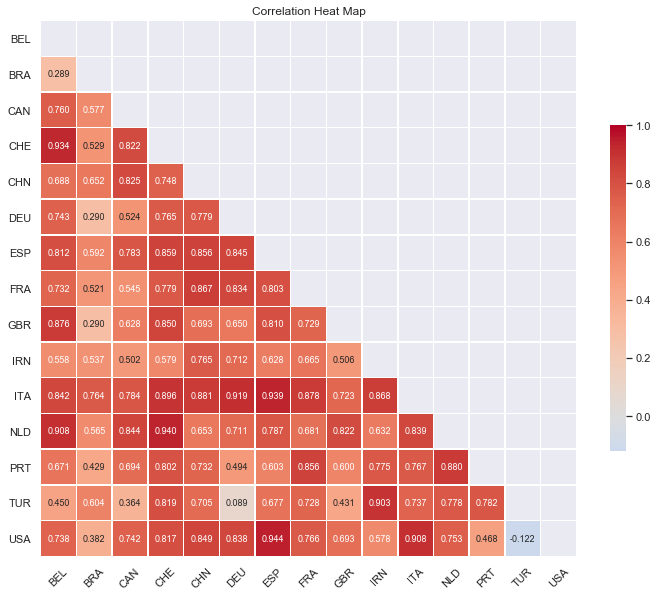

In [17]:
df = pd.DataFrame(covid_gt100.pivot(index='days_since_100',columns='countryterritoryCode',values='double_time_case').to_records()).drop(['days_since_100'],axis=1) 

print("-----correlation of doubling time of case for 15 countries-----------")
corr_chart(df)

-----correlation of doubling time of Deaths for 15 countries-----------


<Figure size 432x288 with 0 Axes>

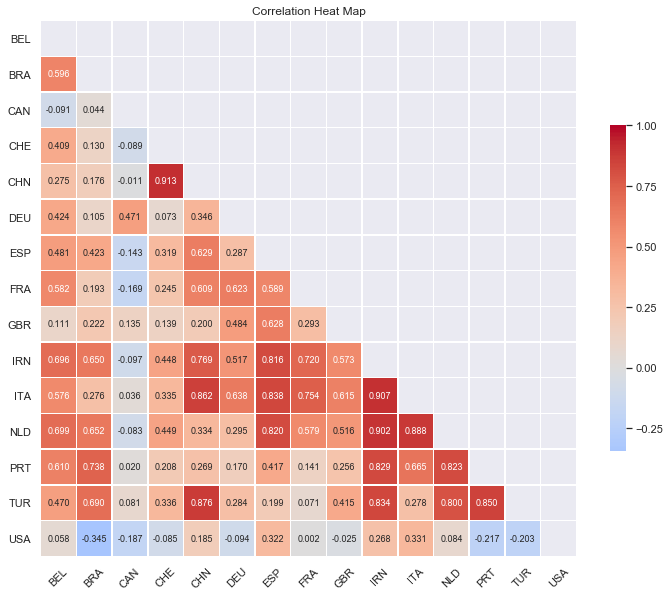

In [18]:
df = pd.DataFrame(covid_gt100.pivot(index='days_since_100',columns='countryterritoryCode',values='double_time_deaths').to_records()).drop(['days_since_100'],axis=1) 

print("-----correlation of doubling time of Deaths for 15 countries-----------")

corr_chart(df)

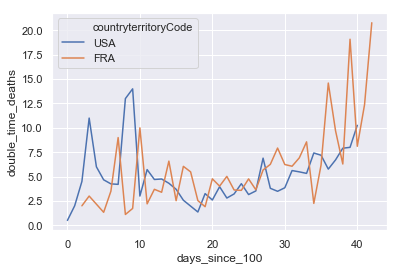

In [19]:
# USA and FRA
filt = ["USA","FRA"]
mask = covid_gt100.countryterritoryCode.isin(filt)
ax = sns.lineplot(x="days_since_100", y="double_time_deaths", hue="countryterritoryCode", data=covid_gt100[mask])

-----correlation of Mortality rates of Deaths for 15 countries-----------


<Figure size 432x288 with 0 Axes>

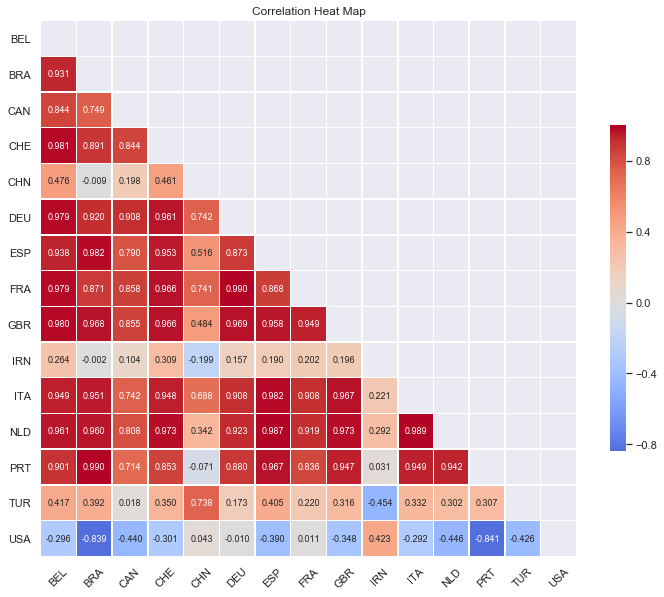

In [20]:
df = pd.DataFrame(covid_gt100.pivot(index='days_since_100',columns='countryterritoryCode',values='mortality_rate').to_records()).drop(['days_since_100'],axis=1) 

print("-----correlation of Mortality rates of Deaths for 15 countries-----------")
corr_chart(df)


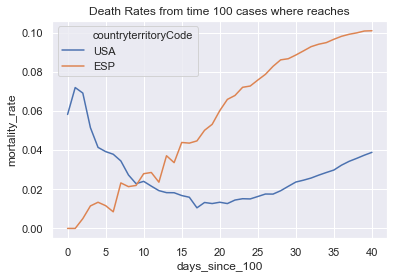

In [28]:
# The US has high negative correlation of mortality rates ralative to other countires
# We can plot US and AUT (high negative corr) for comparison
# Filter US with another counter with high negative correlation

filt = ["USA","ESP"]
mask = covid_gt100.countryterritoryCode.isin(filt)
ax = sns.lineplot(x="days_since_100", y="mortality_rate", hue="countryterritoryCode",   
                  data=covid_gt100[mask])
plt.title("Death Rates from time 100 cases where reaches");

-----------Mortality Rates though time------------


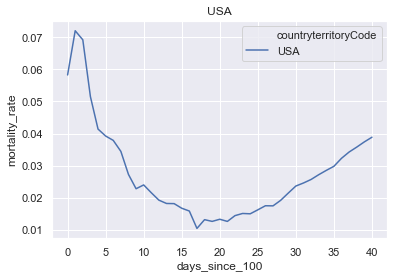

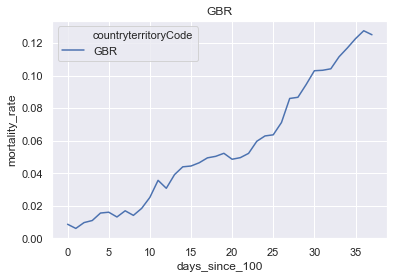

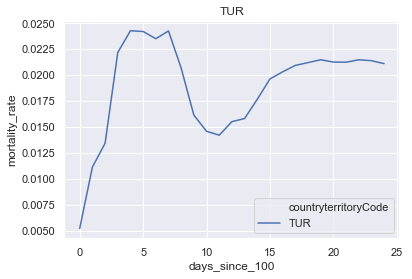

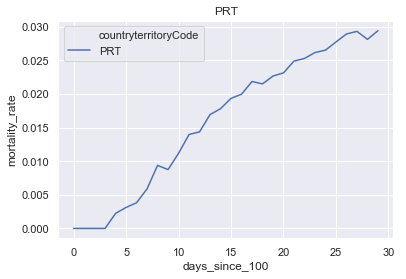

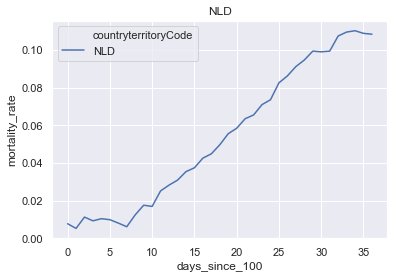

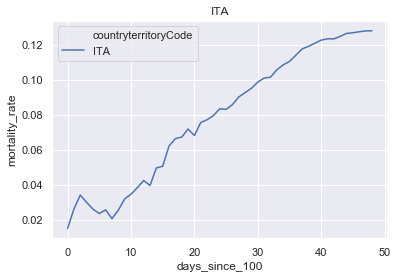

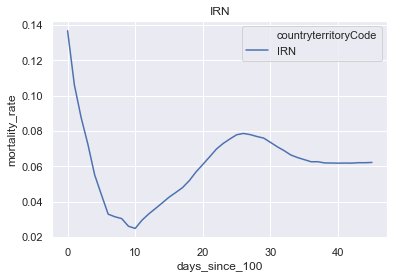

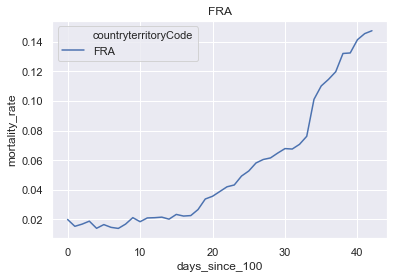

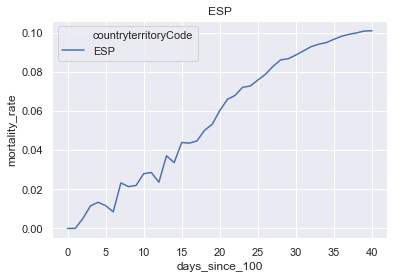

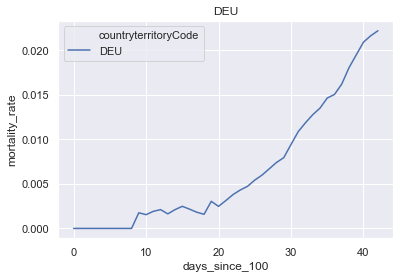

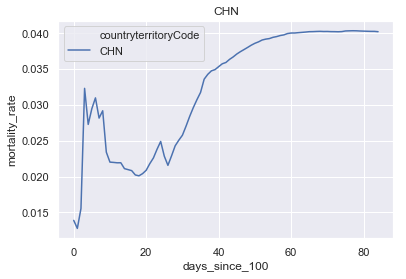

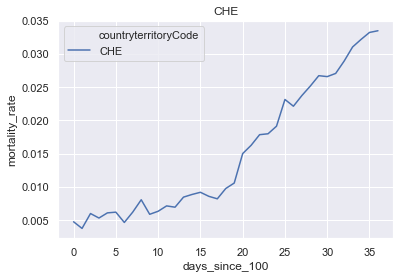

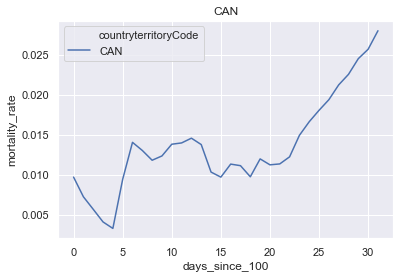

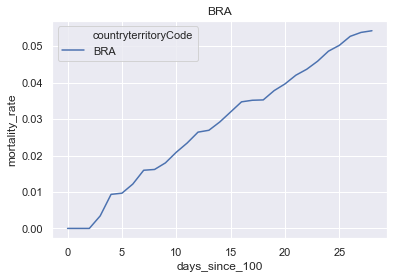

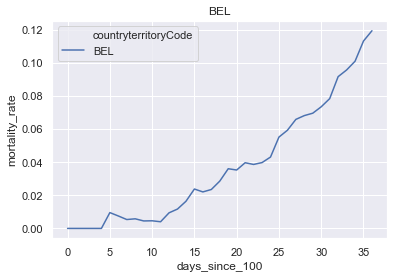

In [22]:
# Plot mortality rates by countries through time based with index at 0 when cases reach 100

print('-----------Mortality Rates though time------------')
for country in covid_gt100.countryterritoryCode.unique().tolist():
    mask = covid_gt100.countryterritoryCode.isin([country])
    standard_fig, ax = plt.subplots()
    ax = sns.lineplot(x="days_since_100", y="mortality_rate", hue="countryterritoryCode",   
                      data=covid_gt100[mask])
    plt.title(country)

# Doubling rates by country

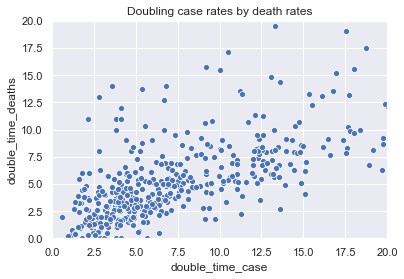

In [23]:
#scatter plot  of doubling rates 
mask = (covid_gt100['double_time_case'] <20) &  (covid_gt100['double_time_deaths'] <20)
scatter_plot =  sns.scatterplot(x="double_time_case", y="double_time_deaths", data=covid_gt100 )
scatter_plot.set(ylim=(0, 20)) 
scatter_plot.set(xlim=(0, 20))
 
plt.title("Doubling case rates by death rates");


-----------Doubling Rates by Country------------


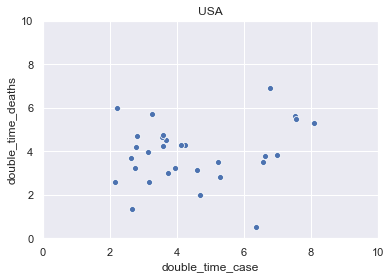

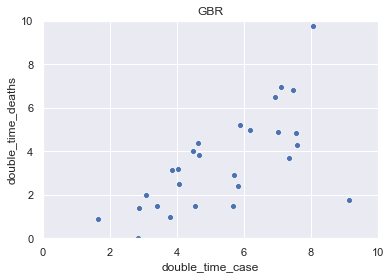

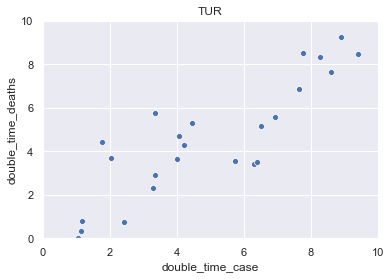

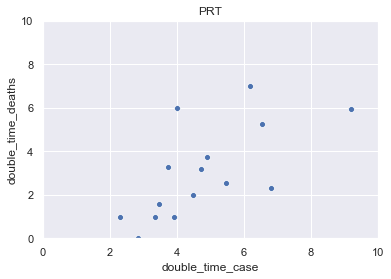

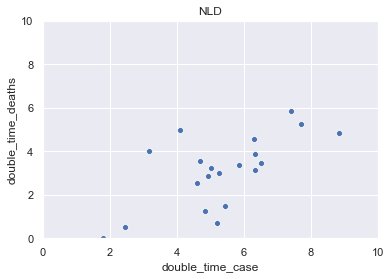

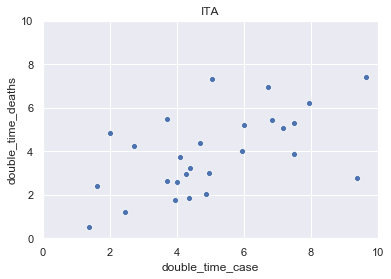

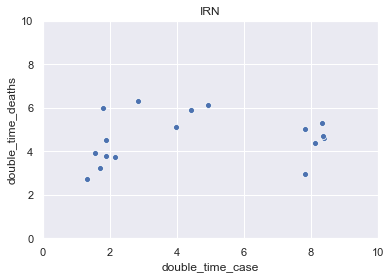

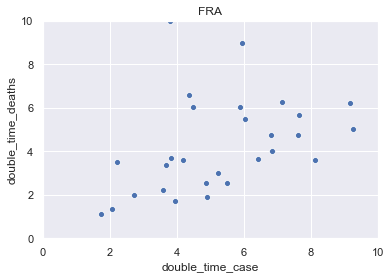

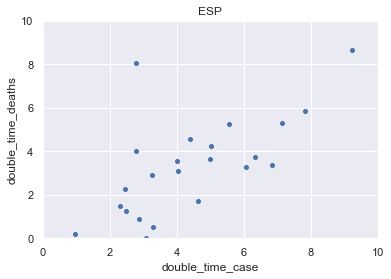

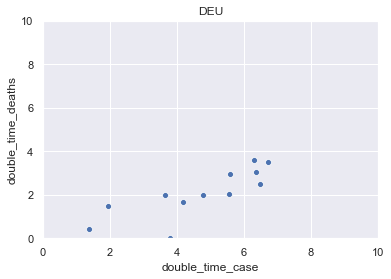

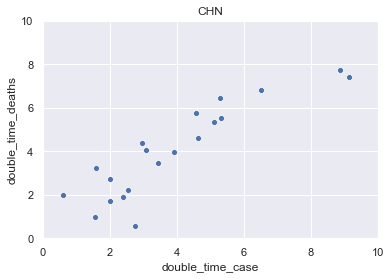

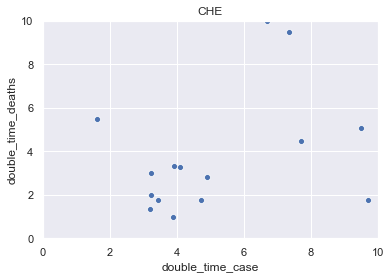

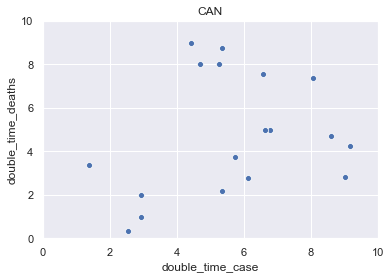

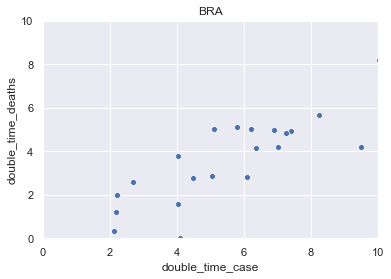

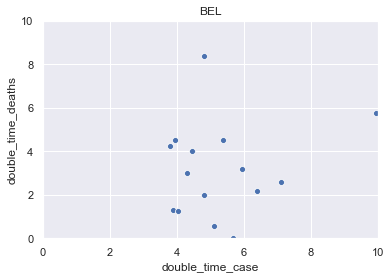

In [24]:
# by country and zomming on
print('-----------Doubling Rates by Country------------')
for country in covid_gt100.countryterritoryCode.unique().tolist():
    mask = covid_gt100['countryterritoryCode']==country
    
    standard_fig, ax = plt.subplots()

    scatter_plot =  sns.scatterplot(x="double_time_case", y="double_time_deaths", data=covid_gt100[mask])
    scatter_plot.set(ylim=(0, 10)) 
    scatter_plot.set(xlim=(0, 10))
    plt.title(country)



# Transformations

c:\python35\lib\site-packages\sklearn\preprocessing\data.py:2239: UserWarning: n_quantiles (1000) is greater than the total number of samples (613). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))


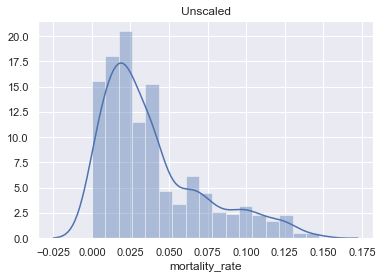

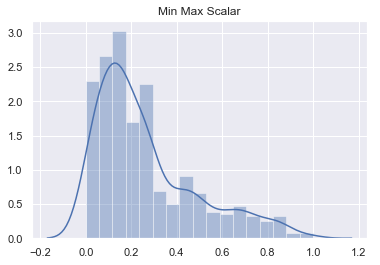

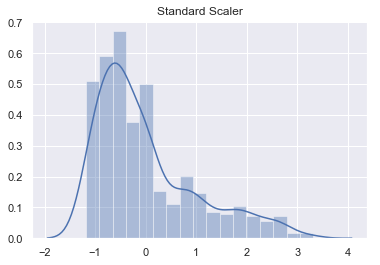

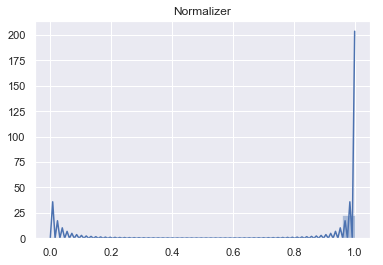

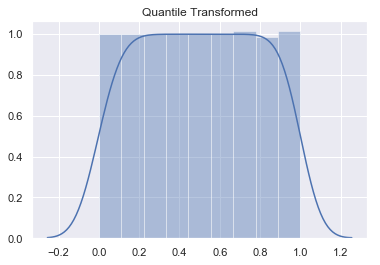

In [25]:
# transformations a la Scikit Learn
# select variable to examine, eliminating missing data codes
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer  

covid_gt100.replace([np.inf, -np.inf], np.nan,inplace=True)

X =  covid_gt100['mortality_rate'].dropna() 


standard_fig, ax = plt.subplots()
sns.distplot(X).set_title('Unscaled') 

standard_fig, ax = plt.subplots()
sns.distplot(MinMaxScaler().fit_transform(X.values.reshape(-1, 1))).set_title('Min Max Scalar')

standard_fig, ax = plt.subplots()
sns.distplot(StandardScaler().fit_transform(X.values.reshape(-1, 1))).set_title('Standard Scaler') 

standard_fig, ax = plt.subplots()
sns.distplot(Normalizer().fit_transform(X.values.reshape(-1, 1))).set_title('Normalizer') 


standard_fig, ax = plt.subplots()
sns.distplot(QuantileTransformer ().fit_transform(X.values.reshape(-1, 1))).set_title('Quantile Transformed');
